## What we know
- Have Binary PPI Network and BSASA PPI network
- Have Binary PPI Distance (taxicab)
- Could improve the reference with a PPI score from logisitc regression

- AP-MS profile similarity is negativley correlated to Binary PPI Network distance
- 

## How to incorporate probabilistic composite connectivity?
- Softened composite connectivity?
- Restraint for the composite mean that the sum of the edge must equal N - 1
- What is N? N is the number of the proteins in the composite.
- What if the number of proteins in the composite is given by a random variable N ~ p(N)
- Also is a composite defined over a specific condition?
- Let's say each composite has a vector where each element i has a probability of being in the composite
- N is then the sum of p(i)
- The sum of all edges must be at least N - 1
- profile similarity * independant saint scores


- How many "composites" are there?
- Imagine a compoiste for each condition M conditions
- We have the SAINT scores per composite, composite connectivity is applied per condition
- The network is an average over all conditions
- Therefore, average composite connectivity must be satisfied
- Essentially, attempt composite connectivity for each of the M conditions
- The restaint is the sum of the edges must be less than N - 1.
- 
- Sparsity - we shouldn't assume a fully connected network


In [791]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pickle as pkl
import xarray as xr
from numpyro.distributions.constraints import Constraint
import pandas as pd
from pathlib import Path
import math
import scipy as sp
# try and fit the data to a model 

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
import jax
from numpyro.contrib.funsor import config_enumerate, infer_discrete
from numpyro.infer import NUTS, MCMC
import jax.numpy as jnp
import arviz as az
import numpyro.distributions as dist
from jax.tree_util import Partial
import sympy as sympy
import jax.scipy as jsp
import inspect
from collections import namedtuple
import blackjax
import blackjax.smc.resampling as resampling
from numpyro.distributions.transforms import Transform
from numpyro.distributions import constraints
import numpy as np
import numpy.typing as npt
from jax.tree_util import tree_flatten, tree_unflatten

from functools import partial
from typing import Any

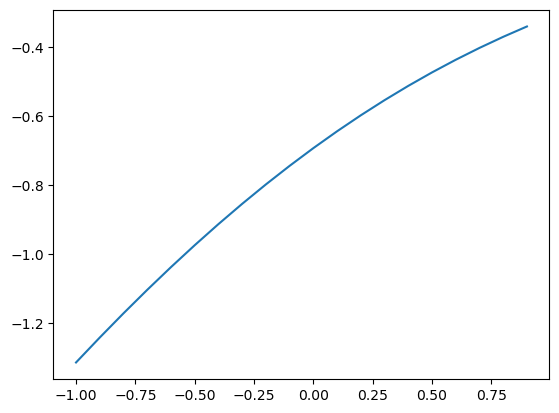

In [931]:
x = np.arange(-1, 1, 0.1)
y = sklearn.linear_model.LogisticRegression.


In [933]:
import sklearn

In [788]:
# The purpose of types for this notebook is for developer documention, not type checkers
# JAX typing see : https://jax.readthedocs.io/en/latest/jep/12049-type-annotations.html
Array = Any
Shape = jax.core.Shape

In [2]:
import _model_variations as mv

In [3]:
# Notebook Bools
CALCULATE_DISTANCE_REFERENCE = False
SAVE_DISTANCE_REFERENCE = False

In [4]:
with open("direct_benchmark.pkl", 'rb') as f:
    direct_benchmark = pkl.load(f)
reference_matrix = direct_benchmark.reference.matrix

In [661]:
if CALCULATE_DISTANCE_REFERENCE:
    D_reference = mv.shortest_paths_up_to_N(direct_benchmark.reference.matrix.values, 25)
    D_reference = xr.DataArray(D_reference, coords=reference_matrix.coords)
else:
    D_reference = mv.load("direct_reference_distance_matrix_up_to_25.pkl")

In [658]:
if SAVE_DISTANCE_REFERENCE:
    with open("direct_reference_distance_matrix_up_to_25.pkl", "wb") as f:
        pkl.dump(D_reference, f)

In [668]:
# Correct D_reference so that self distances are 0
N, _ = D_reference.shape
temp = D_reference.values
diag = np.diag_indices(N)
#temp[np.diag_indices(N)] = 0 
temp[diag] = 0
D_reference = xr.DataArray(temp, coords=D_reference.coords)

In [669]:
D_reference

<xarray.DataArray (preyu: 3005, preyv: 3005)>
array([[ 0,  1,  1, ..., 25, 25, 25],
       [ 1,  0,  1, ..., 25, 25, 25],
       [ 1,  1,  0, ..., 25, 25, 25],
       ...,
       [25, 25, 25, ...,  0, 25, 25],
       [25, 25, 25, ..., 25,  0, 25],
       [25, 25, 25, ..., 25, 25,  0]], dtype=int32)
Coordinates:
  * preyu    (preyu) <U14 '1433B' '1433E' '1433F' ... 'tatprotein' 'vifprotein'
  * preyv    (preyv) <U14 '1433B' '1433E' '1433F' ... 'tatprotein' 'vifprotein'

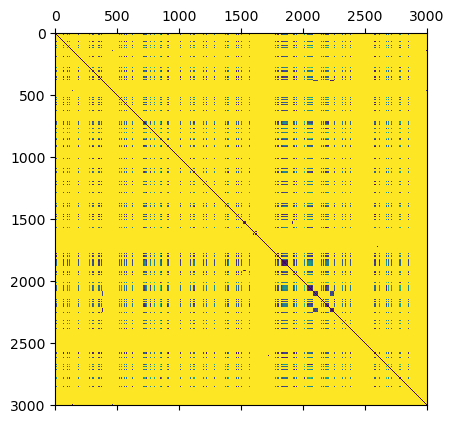

In [667]:
plt.matshow(temp)

In [7]:
apms_pearson_r = mv.load("xr_apms_correlation_matrix.pkl")

In [8]:
assert apms_pearson_r.shape == D_reference.shape

In [13]:
# Id Mapping
reference_dict = mv.preyu2uid_mapping_dict()
uid2gene_name = {val: key for key,val in reference_dict.items()}
gene_ids = [uid2gene_name[i] for i in apms_pearson_r.uid_preyu.values]
apms_pearson_r = xr.DataArray(apms_pearson_r.values, coords={"preyu": gene_ids, "preyv": gene_ids})

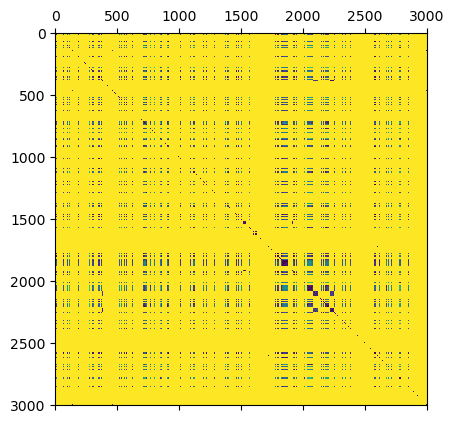

In [26]:
plt.matshow(D_reference.values)

In [30]:
assert np.alltrue(D_reference.preyu == apms_pearson_r.preyu)
D_flat = mv.matrix2flat(D_reference.values)
pearson_r_flat = mv.matrix2flat(apms_pearson_r.values)

/Users/aji/Projects/benchmark_results/notebooks/_model_variations.py:661: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = jnp.zeros(N, dtype=M.dtype)


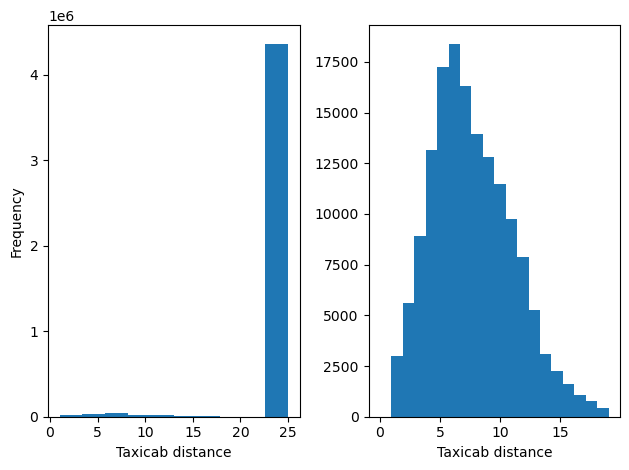

In [40]:
D_flat = np.array(D_flat)
pearson_r_flat = np.array(pearson_r_flat)

fig, ax = plt.subplots(1, 2)
ax[0].hist(D_flat)
ax[1].hist(D_flat, range=(0, 19), bins=20)
ax[0].set_xlabel("Taxicab distance")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Taxicab distance")
plt.tight_layout()

Text(0, 0.5, 'Distance')

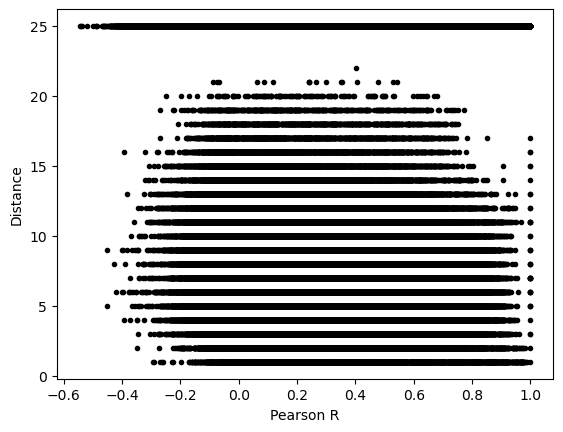

In [47]:
plt.plot(pearson_r_flat, D_flat, 'k.')
plt.xlabel("Pearson R")
plt.ylabel("Distance")

In [50]:
D_at_small_correlations = D_flat[pearson_r_flat <= 0.6]
D_at_large_correlations = D_flat[pearson_r_flat > 0.6]

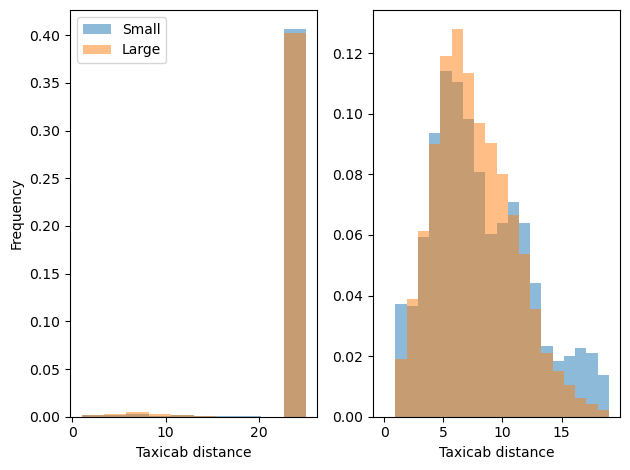

In [84]:
len(pearson_r_flat) % 2
#middle_index = len(pearson_r_flat) // 2
middle_index = int(len(pearson_r_flat) * 0.1)

small_D = D_flat[0:middle_index]
large_D = D_flat[middle_index:-1]

fig, ax = plt.subplots(1, 2)
ax[0].hist(small_D, label="Small", alpha=0.5, density=True)
ax[0].hist(large_D, label="Large", alpha=0.5, density=True)

ax[1].hist(small_D, range=(0, 19), alpha=0.5, bins=20, density=True)
ax[1].hist(large_D, range=(0, 19), alpha=0.5, bins=20, density=True)
ax[0].set_xlabel("Taxicab distance")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Taxicab distance")
ax[0].legend()
plt.tight_layout()

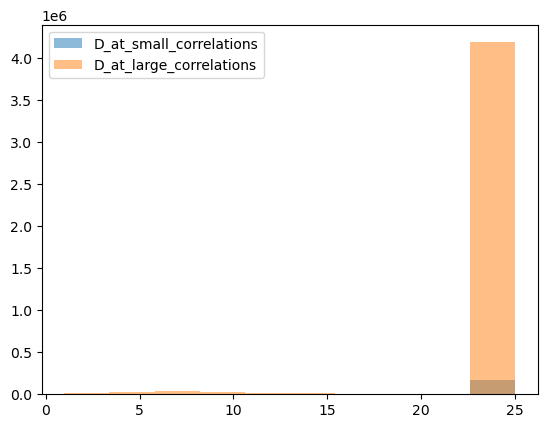

In [56]:
D_at_small_correlations = D_flat[pearson_r_flat <= 0.6]
D_at_large_correlations = D_flat[pearson_r_flat > 0.6]
ax[0].hist(D_flat)
ax[1].hist(D_flat, range=(0, 19), bins=20)
ax[0].set_xlabel("Taxicab distance")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Taxicab distance")
plt.tight_layout()

plt.hist(D_at_large_correlations, label="D_at_small_correlations", alpha=0.5)
plt.hist(D_at_small_correlations, label="D_at_large_correlations", alpha=0.5)


plt.legend()

4329964

Text(0, 0.5, 'Distance')

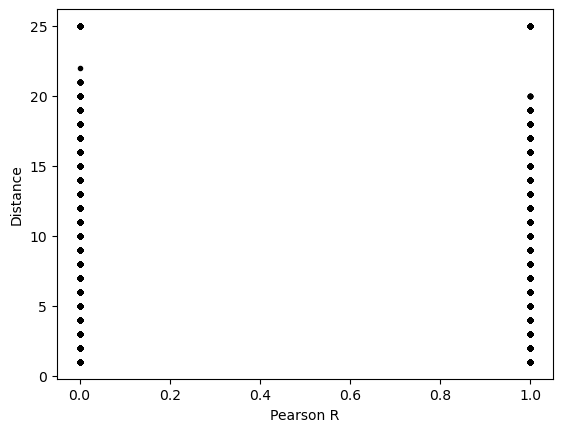

In [49]:
plt.plot(pearson_r_flat > 0.6, D_flat, 'k.')
plt.xlabel("Pearson R")
plt.ylabel("Distance")

In [ ]:
N, _ = D_reference.shape
M = math.comb(N, 2)
assert len(D_flat) == M

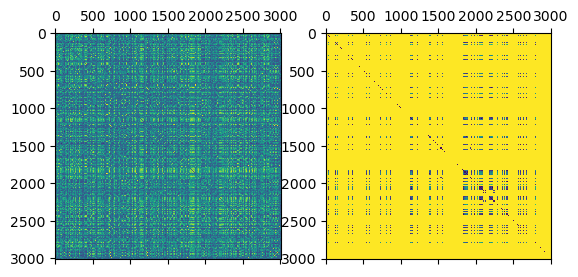

In [100]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(apms_pearson_r.values)
ax[1].matshow(D_reference)

In [672]:
mini_sel = ["ELOB", "ELOC", "vifprotein", "PEBB",
            "CUL5", "CUL2", "RBX1", "RBX2", "NEDD8", "ARI1", "ARI2"
            ]

apms_mini = apms_pearson_r.sel(preyu=mini_sel, preyv=mini_sel)
D_mini = D_reference.sel(preyu=mini_sel, preyv=mini_sel)
#D_mini[np.diag_indices_from(D_mini.values)] = 0
tril_indices = np.tril_indices_from(apms_mini, k=-1)

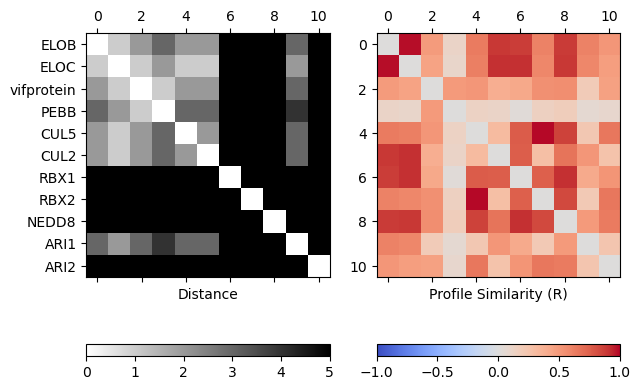

In [673]:
fig, ax = plt.subplots(1, 2)#, figsize=(8, 8))
for a in ax.flat:
    a.set_aspect("equal", "box")

mappable = ax[0].matshow(D_mini, cmap="binary", vmin=0, vmax=5)
plt.colorbar(mappable, location="bottom")
mappable = ax[1].matshow(apms_mini, cmap="coolwarm", vmin=-1, vmax=1)
ax[0].set_yticks(np.arange(len(D_mini)), labels=mini_sel)
#ax[0].set_xticks(np.arange(len(D_mini)), labels=mini_sel)
plt.tight_layout()
plt.colorbar(mappable, location="bottom")
ax[0].set_xlabel("Distance")
ax[1].set_xlabel("Profile Similarity (R)")
plt.show()

In [674]:
def plot_expected_correlation_decay():
    """
    Rank prey by max saint score
    
    
    
    """
    ...
    
def get_max_saint_scores(df_new, apms_pearson_r):
    max_saint_score = {k: 0 for k in apms_pearson_r.preyu.values}

    for label, r in df_new.iterrows():
        if label in max_saint_score:
            val = max_saint_score[label]
            saint_score = r['SaintScore']
            if saint_score > val:
                max_saint_score[label] = saint_score
    
    coordinate = np.zeros(len(max_saint_score), dtype="U14")
    scores = np.zeros(len(max_saint_score))
    for i, (key, value) in enumerate(max_saint_score.items()):
        coordinate[i] = key
        scores[i] = value
    return xr.DataArray(scores, coords={"preyu": coordinate})

In [400]:
max_saint_xr = get_max_saint_scores(df_new, apms_pearson_r)
max_saint_xr = xr.DataArray(max_saint_xr.to_pandas().sort_values())

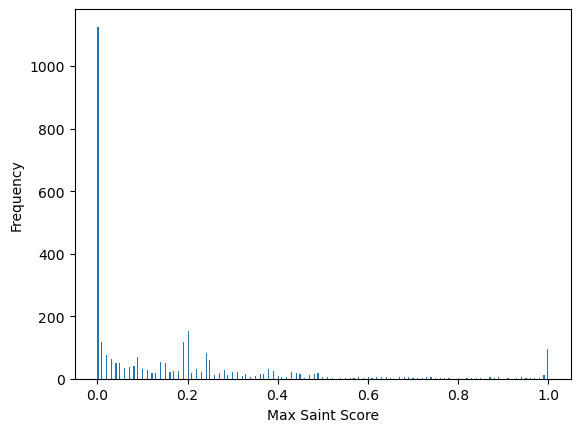

In [408]:
plt.hist(max_saint_xr.values, bins=len(max_saint_xr) // 8)
plt.ylabel("Frequency")
plt.xlabel("Max Saint Score")
plt.show()

In [443]:
top_prey = max_saint_xr.where(max_saint_xr == 1, drop=True)

SyntaxError: invalid syntax (1821142861.py, line 2)

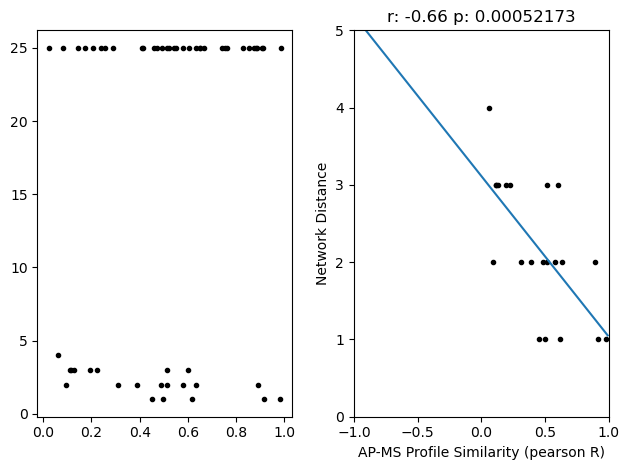

In [863]:
def matrix_regplot(matrix_a, matrix_b, max_distance=10, ylim=5):
    tril_indices = np.tril_indices_from(matrix_a, k=-1)
    a = matrix_a[tril_indices]
    b = matrix_b[tril_indices]
    plt.subplot(121)

    #a = apms_mini.values[tril_indices]
    #b = D_mini.values[tril_indices]
    sel = b < max_distance
    linear_regression = sp.stats.linregress(a[sel], b[sel], alternative='less')
    
    plt.plot(a, b, 'k.')
    plt.subplot(122)
    plt.plot(a, b, 'k.')
    plt.title(f"r: {linear_regression.rvalue:.2f} p: {linear_regression.pvalue:.8f}")


    x = np.arange(-1, 1, 0.01)
    plt.plot(x, linear_regression.slope * x + linear_regression.intercept)

    plt.xlabel("AP-MS Profile Similarity (pearson R)")
    plt.ylabel("Network Distance")
    results = sp.stats.pearsonr(a[sel], b[sel])
    plt.xlim(-1, 1)
    plt.ylim(0, ylim)
    plt.tight_layout()
    plt.show()
    
matrix_regplot(apms_mini.values, D_mini.values)

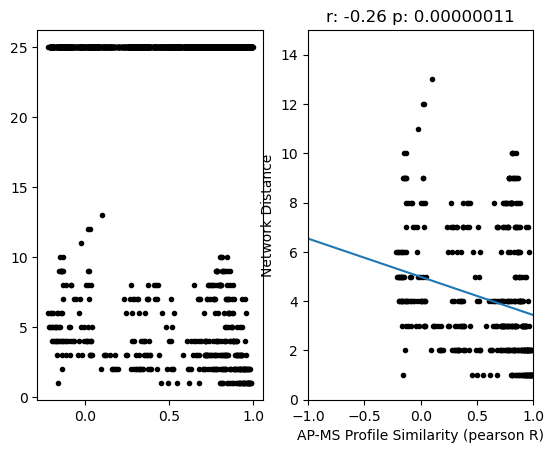

In [450]:
sel = top_prey.preyu.values
matrix_regplot(apms_pearson_r.sel(preyu=sel, preyv=sel).values,
              D_reference.sel(preyu=sel, preyv=sel).values, ylim=15)

In [719]:
def calculate_network_distance_score_correlation(d, s, is_xr=True, max_distance=10):
    """
    d : a distance matrix xarray
    s : a score matrix xarray
    """
    
    if is_xr:
        d = d.values
        s = s.values
    assert d.shape == s.shape, (d.shape, s.shape)
    tril_indices = np.tril_indices_from(d, k=-1)
    d = d[tril_indices]
    s = s[tril_indices]
    
    sel = d < max_distance
    linear_regression = sp.stats.linregress(d[sel], s[sel], alternative='less')
    return linear_regression



def get_shortest_distance_from_any_bait(D_reference, bait_names = None) -> xr.DataArray:
    """
    
    """
    if bait_names is None:
        bait_names = ["CUL5", "PEBB", "ELOB"]
    bait_matrix = D_reference.sel(preyv=bait_names)
    return bait_matrix.min(axis=1)
    

In [789]:
min_distance_to_a_bait = get_shortest_distance_from_any_bait(D_reference)

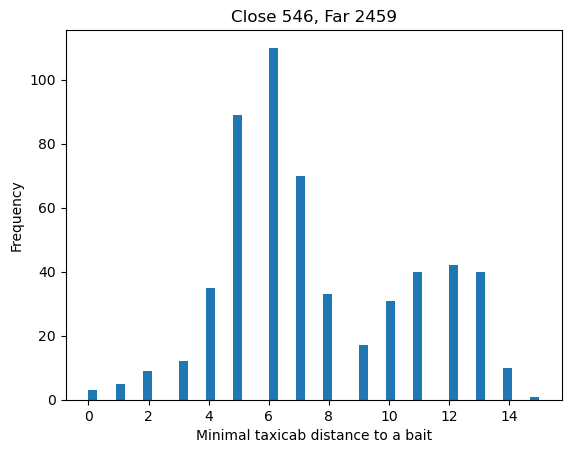

In [695]:
plt.hist(min_distance_to_a_bait, bins=50, range=(0,15))
plt.xlabel("Minimal taxicab distance to a bait")
plt.ylabel("Frequency")
plt.title(f"Close {np.sum(min_distance_to_a_bait.values < 15)}, Far {np.sum(min_distance_to_a_bait.values >= 15)}")
plt.show()

Text(0.5, 0, 'Min Distance to Bait')

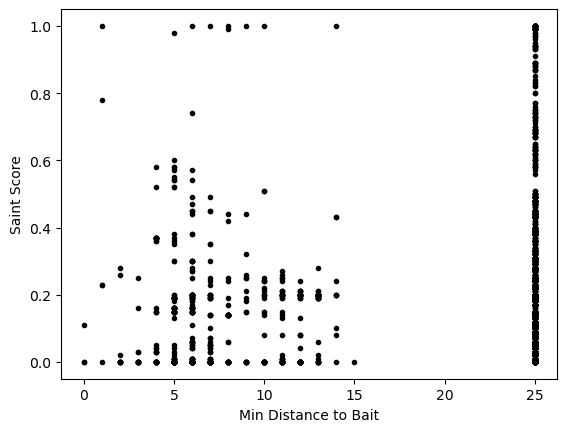

In [778]:
plt.plot(min_distance_to_a_bait, max_saint_xr, 'k.')
plt.ylabel("Saint Score")
plt.xlabel("Min Distance to Bait")

In [724]:
bait_matrix = get_shortest_distance_from_any_bait(D_reference)

In [725]:
calculate_network_distance_score_correlation(D_mini, apms_mini)

LinregressResult(slope=-0.21156384907014134, intercept=0.9065781347289227, rvalue=-0.6634238468374464, pvalue=0.0005217271214695168, stderr=0.05474150255744549, intercept_stderr=0.12865778229762975)

In [817]:
def correlation_decohearence(key, apms_pair_score, D_reference, stepsize=10,
                            max_distance=10, denominator=1):
    # Sort saint scores in ascending order
    #max_saint_scores = xr.DataArray(max_saint_scores.to_pandas().sort_values())
    #for i in range(len(max_saint_xr), 10):
    
    min_distance_from_any_bait = get_shortest_distance_from_any_bait(D_reference)
    min_distance_from_any_bait = xr.DataArray(min_distance_from_any_bait.to_pandas().sort_values())
    
    scores : xr.DataArray = min_distance_from_any_bait
    
    
    # Select top and bottom N saint scores

    N = len(scores) // (denominator * stepsize)
    columns=["N", "slope", "intercept", "rvalue", "pvalue", "stderr", "intercept_stderr"]
    output = np.zeros((N, len(columns)))
    ctrl_scores = pd.DataFrame(output.copy(), columns=columns)
    bot_scores = pd.DataFrame(output.copy(), columns=columns)

    k=0
    f = partial(calculate_network_distance_score_correlation, max_distance=max_distance)
    for i in range(stepsize, len(scores) // denominator, stepsize):
        
        bot_N : xr.DataArray = scores[0:i]
        ctrl_N : xr.DataArray = bot_N.copy()
        
        bot_prey_sel : npt.NDArray = bot_N.preyu.values #U14
        ctrl_prey_sel : npt.NDArray = bot_prey_sel.copy() #U14
        
        # Select corresponding apms data
        #ctrl_apms = apms_pair_score.sel(preyu=ctrl_prey_sel, preyv=ctrl_prey_sel)
        bot_apms = apms_pair_score.sel(preyu=bot_prey_sel, preyv=bot_prey_sel)
        
        # select corresponding ppi reference
        D_ref = D_reference.sel(preyu=bot_prey_sel, preyv=bot_prey_sel)
        #bot_D_ref = D_reference.sel(preyu=bot_prey_sel, preyv=bot_prey_sel)
        
        # shuffle the control
        key, key2 = jax.random.split(key)
        shfl_ctrl_idx : Array = jax.random.permutation(key2, len(ctrl_N))
        
        ctrl_apms = bot_apms.copy().isel(preyu=shfl_ctrl_idx) # shuffle the AP-MS data
        
        ctrl_reg = f(ctrl_apms, D_ref)._asdict()
        bot_reg = f(bot_apms,   D_ref)._asdict()
        
        ctrl_reg = pd.Series({"N": i} | ctrl_reg)
        bot_reg = pd.Series({"N": i} | bot_reg)
        
        ctrl_scores.iloc[k, :] = ctrl_reg
        bot_scores.iloc[k, :] = bot_reg
        k += 1
        #if k > 2:
        #    break
    return ctrl_scores, bot_scores

In [818]:
key = jax.random.PRNGKey(12)
t, b = correlation_decohearence(key, apms_pearson_r, D_reference, stepsize=5, max_distance=15)

/Users/aji/opt/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


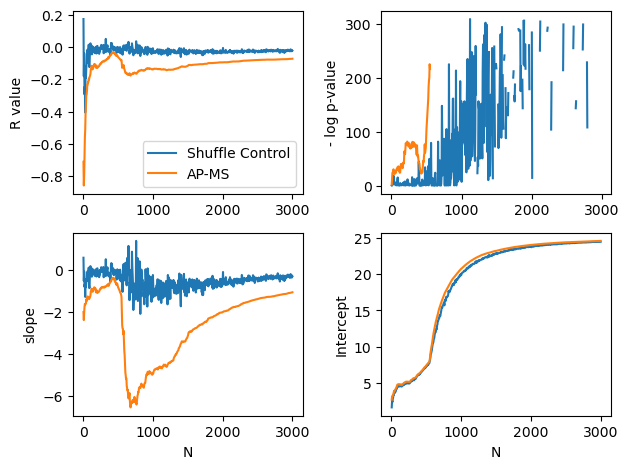

In [822]:
# Drop the last row
t = t.drop(600)
b = b.drop(600)

plt.subplot(221)
plt.plot(t['N'], t['rvalue'], label="Shuffle Control")
plt.plot(b['N'], b['rvalue'], label="AP-MS")
plt.legend()
#plt.xlabel("N")
plt.ylabel("R value")
plt.subplot(222)
plt.plot(t['N'], -np.log10(t['pvalue']))
plt.plot(t['N'], -np.log10(b['pvalue']))
#plt.xlim(0,50)
#plt.ylim(0, 15)
plt.ylabel("- log p-value")
#plt.hlines(5, 0, 1500, 'r')
#plt.ylim(0, 0.0000000000001)

plt.subplot(223)
plt.plot(t['N'], t['slope'])
plt.plot(t['N'], b['slope'])
plt.xlabel("N")
plt.ylabel("slope")
plt.tight_layout()
plt.subplot(224)
plt.plot(t['N'], t['intercept'])
plt.plot(t['N'], b['intercept'])
plt.ylabel("Intercept")
plt.xlabel("N")
plt.show()

(0.0, 546.0)

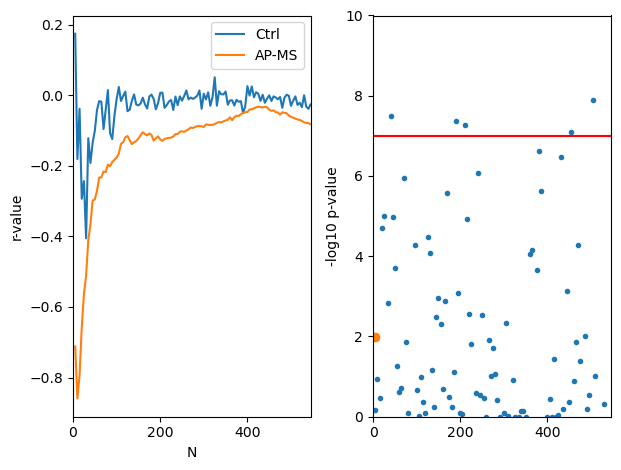

In [861]:
plt.subplot(121)
plt.plot(t['N'], t['rvalue'], label="Ctrl")
plt.plot(t['N'], b['rvalue'], label="AP-MS")
plt.ylabel("r-value")
plt.legend()
plt.xlabel("N")
plt.xlim(0, 546)

plt.xlabel
plt.subplot(122)
plt.plot(t['N'], -np.log10(t['pvalue']), '.', label="Ctrl")
plt.plot(t['N'], -np.log10(b['pvalue']), 'o', label="AP-MS")
plt.hlines(7, 0, 546, color='r')
plt.ylabel("-log10 p-value")
plt.ylim(0, 10)
plt.tight_layout()
plt.xlim(0, 546)

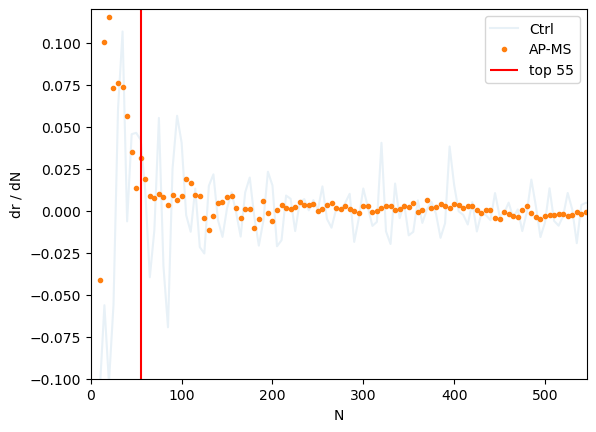

In [901]:
drc = np.gradient(t['rvalue'])
dr = np.gradient(b['rvalue'])
plt.plot(t['N'], drc, alpha=0.1, label="Ctrl")
plt.plot(t['N'], dr, '.', label="AP-MS")
plt.xlim(0, 546)
plt.ylabel("dr / dN")
plt.vlines(55, -0.2, 0.15, color='r', label="top 55")
plt.ylim(-0.1, 0.12)
plt.xlabel("N")
plt.legend()


## Idea

The AP-MS data follows a weakst link mechanism
Use BSASA as a proxy (where is it)
Calculate the pairwise BSASA matrix
Take the reciprocal (invert BSASA matrix)

Calculate the all pairs shortest paths BSASA (Networkkit?) - corresponding to strongest chain
Correlate


## Restraints
- have p(PPI | r-value)

In [917]:
d_train_idx = (0, 546)
d_pred_idx = (546, 3005)
unknown_prey = min_distance_to_a_bait.isel(preyu=np.arange(*d_pred_idx)).preyu.values

In [918]:
unknown_prey

array(['CYBP', 'CYC', 'CYFP1', ..., 'revprotein', 'tatprotein',
       'vifprotein'], dtype='<U14')

In [920]:
d = pd.read_csv("../significant_cifs/BSASA_reference.csv")

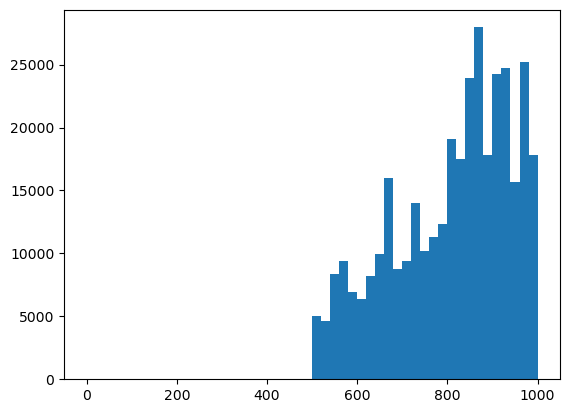

In [925]:
plt.hist(d['bsasa_lst'], bins=50, range=(0,1000))
plt.show()

In [923]:
d

,Prey1,Prey2,PDBID,Chain1,Chain2,bsasa_lst
0,NaN,NaN,10gs,A,B,2370.3984
1,NaN,P21266,10gs,A,B,2370.3984
2,NaN,P09211,10gs,A,B,2370.3984
3,P21266,NaN,10gs,A,B,2370.3984
4,P21266,P21266,10gs,A,B,2370.3984
...,...,...,...,...,...,...
1336201,P07195,P07195,9ldt,A,B,17629.2460
1336202,P07195,P00338,9ldt,A,B,17629.2460
1336203,P00338,NaN,9ldt,A,B,17629.2460
1336204,P00338,P07195,9ldt,A,B,17629.2460


In [905]:
min_distance_to_a_bait

<xarray.DataArray (preyu: 3005)>
array([25, 25, 25, ..., 25, 25,  1], dtype=int32)
Coordinates:
  * preyu    (preyu) <U14 '1433B' '1433E' '1433F' ... 'tatprotein' 'vifprotein'

(0.0, 546.0)

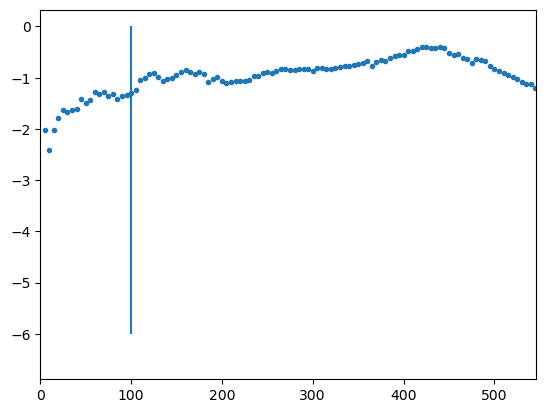

In [887]:
plt.plot(b['N'], b['slope'], '.')
plt.vlines(100, -6, 0)
plt.xlim(0, 546)

### Why does the strength of ascociation decay at larger N?
1. Uncertainty in reference.
    a. Shortest distances in PDB may be closer than what we know
    b. May miss certain distances based on BSASA cutoff
2. Including more proteins 

(0.0, 546.0)

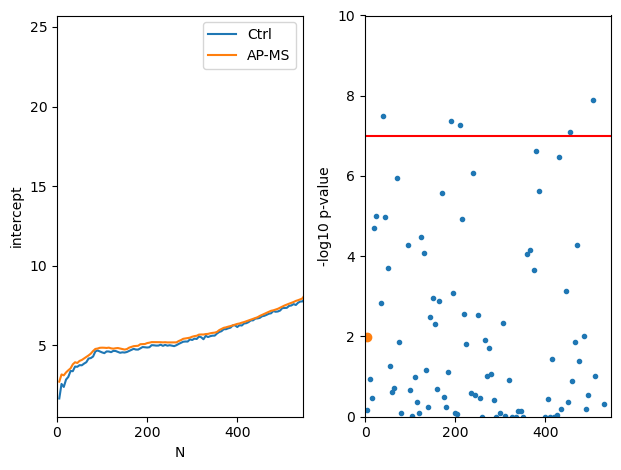

In [862]:
plt.subplot(121)
plt.plot(t['N'], t['intercept'], label="Ctrl")
plt.plot(t['N'], b['intercept'], label="AP-MS")
plt.ylabel("intercept")
plt.legend()
plt.xlabel("N")
plt.xlim(0, 546)
plt.subplot(122)
plt.plot(t['N'], -np.log10(t['pvalue']), '.', label="Ctrl")
plt.plot(t['N'], -np.log10(b['pvalue']), 'o', label="AP-MS")
plt.hlines(7, 0, 546, color='r')
plt.ylabel("-log10 p-value")
plt.ylim(0, 10)
plt.tight_layout()
plt.xlim(0, 546)

Text(0, 0.5, 'Slope')

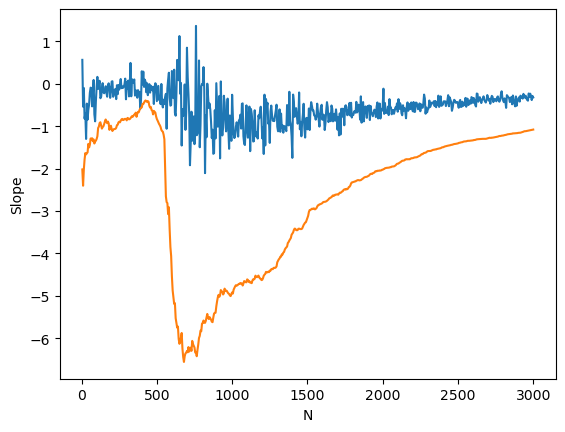

In [864]:
plt.plot(t['N'], t['slope'])
plt.plot(t['N'], b['slope'])
plt.xlabel("N")
plt.ylabel("Slope")

In [ ]:
# Do a scatter plot of minimal bait distance to spectral count variation

Conclusions and Implications for Modeling
- We know shortest bait prey paths for 546 (18%) nodes and don't know for 2459 (81%) nodes
- Thus 148, 785 edges are supported by at least one PDB bait prey path
- 3,022,111 edges are not supported by any bait prey path
- Effects that add to decohearance are
    1. Missing information in the PDB
    2. type II annotation errors
    3. variation in AP-MS data
- At close network distances, profile similarity is negativley correlated with network distances
- What are the top ranked edges with no support in the PDB?
- Do I trust the SAINT score?

In [541]:

df = pd.DataFrame(np.zeros((4, 6)), columns=list(t._asdict().keys()))

TypeError: can only concatenate list (not "dict") to list

In [529]:
df + pd.Series(t._asdict())

,slope,intercept,rvalue,pvalue,stderr,intercept_stderr


In [526]:
pd.Series(t._asdict())

slope                1.569632
intercept           23.060496
rvalue               0.113421
pvalue               0.770908
stderr               2.096804
intercept_stderr     1.037388
dtype: float64

In [306]:
df_new = mv.load("df_new.pkl")

IndexError: index 2 is out of bounds for axis 0 with size 2

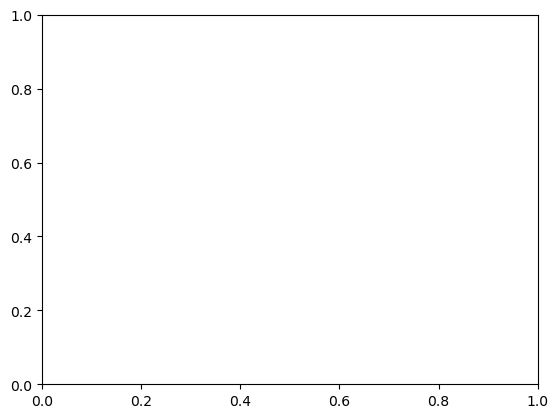

In [256]:
plt.colorbar(mappable, location="bottom")
ax[2].plot(apms_mini[tril_indices], D_mini[tril_indices], 'k.')
ax[2].set_xlabel("Pearson R")
ax[2].set_ylabel("Network Distance")
ax[2].set_xlim(-1, 1)
#ax[2].set_aspect("equal", "box")
plt.tight_layout()
plt.show()
#plt.colorbar(mappable, cax=ax[2])

/var/folders/1f/61m6lqyj087gdyy2l44nq5jc0000gp/T/ipykernel_968/2265765760.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


([<matplotlib.axis.YTick at 0x2e161c310>,
 [Text(0, 0, 'ELOB'),
  Text(0, 1, 'ELOC'),
  Text(0, 2, 'vifprotein'),
  Text(0, 3, 'PEBB'),
  Text(0, 4, 'CUL5')])

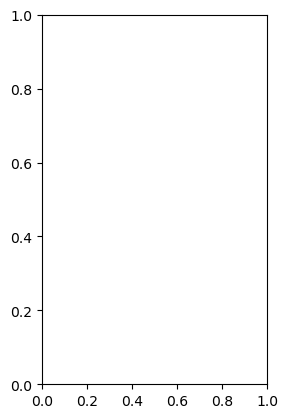

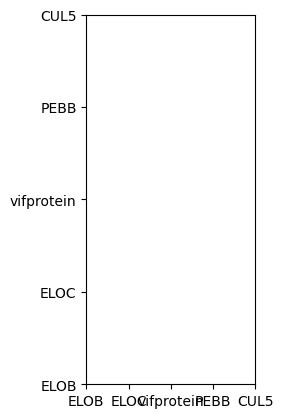

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].matshow(D_mini, cmap="binary")
plt.subplot(122)
plt.xticks(np.arange(len(D_mini)), labels=mini_sel)
plt.yticks(np.arange(len(D_mini)), labels=mini_sel)

/var/folders/1f/61m6lqyj087gdyy2l44nq5jc0000gp/T/ipykernel_968/2627919004.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(mini_sel)


Text(0.5, 1.0, 'D')

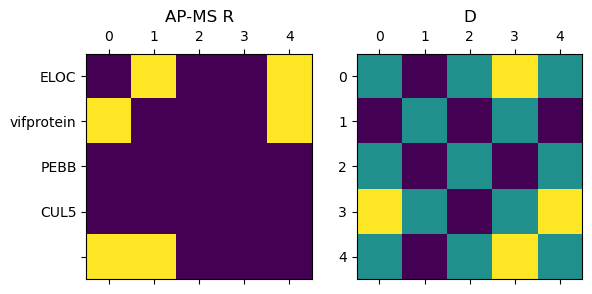

In [115]:
fig, ax = plt.subplots(1, 2)
ax1 = ax[0]
ax[0].matshow(apms_mini > 0.6)
ax[0].set_yticklabels(mini_sel)
#ax1.set_yticklabels(mini_sel)
ax[1].matshow(D_mini)
ax[0].set_title("AP-MS R")
ax[1].set_title("D")

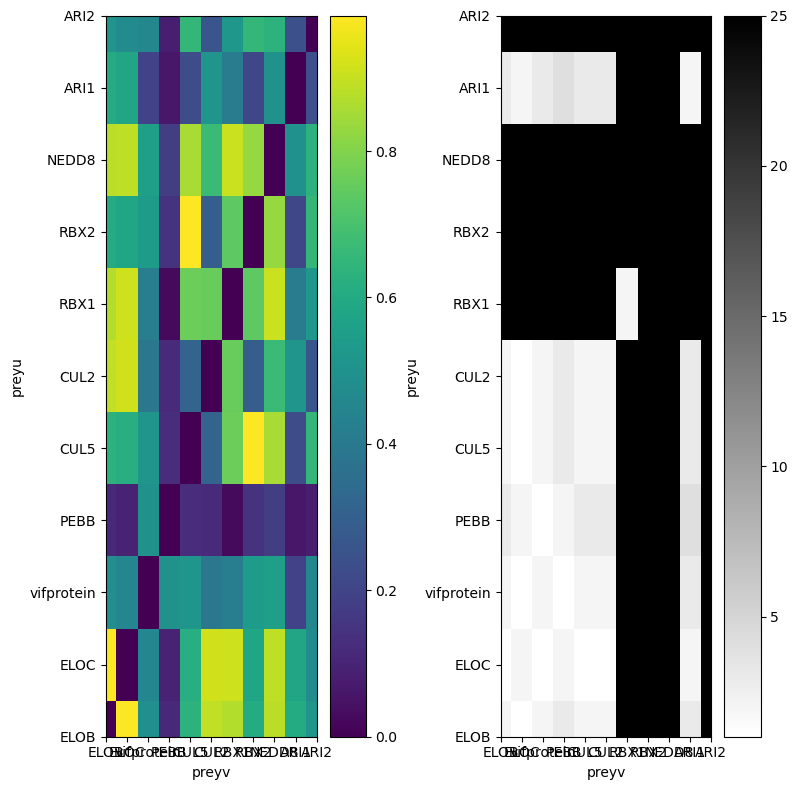

In [427]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
apms_mini.plot(ax=axs[0])
D_mini.plot(ax=axs[1], cmap="binary")
plt.tight_layout()

In [428]:
help(plt.tight_layout)

Help on function tight_layout in module matplotlib.pyplot:

tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)
    Adjust the padding between and around subplots.
    
    To exclude an artist on the Axes from the bounding box calculation
    that determines the subplot parameters (i.e. legend, or annotation),
    set ``a.set_in_layout(False)`` for that artist.
    
    Parameters
    ----------
    pad : float, default: 1.08
        Padding between the figure edge and the edges of subplots,
        as a fraction of the font size.
    h_pad, w_pad : float, default: *pad*
        Padding (height/width) between edges of adjacent subplots,
        as a fraction of the font size.
    rect : tuple (left, bottom, right, top), default: (0, 0, 1, 1)
        A rectangle in normalized figure coordinates into which the whole
        subplots area (including labels) will fit.
    
    See Also
    --------
    .Figure.set_layout_engine
    .pyplot.tight_layout



TypeError: xticks(): Parameter 'labels' can't be set without setting 'ticks'

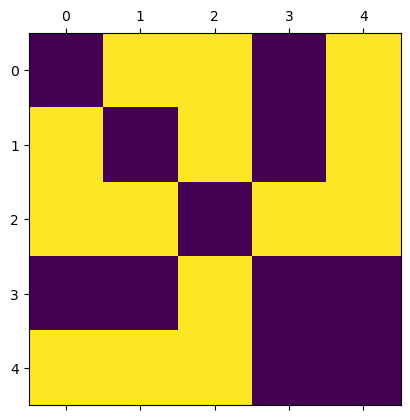

In [120]:
plt.matshow(apms_mini > 0.4)


In [ ]:
mixed = np.tril(D_reference.values, k=-1)


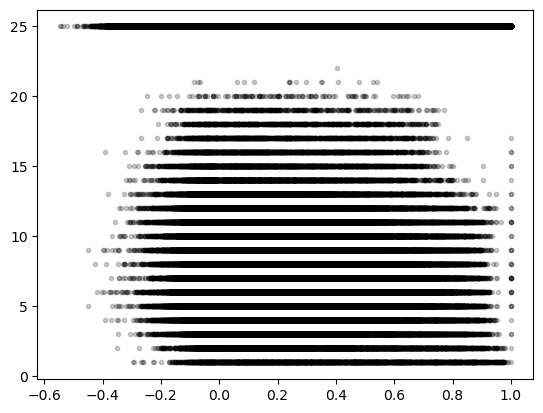

In [87]:
plt.plot(np.ravel(apms_pearson_r.values), np.ravel(D_reference.values), 'k.', alpha=0.1)
plt.show()